In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")

In [4]:
# Load cleaned data
df_clean = pd.read_csv("../data/processed/cleaned_brent_data.csv")
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

In [5]:
# Use log returns for stationarity
returns = df_clean['Log_Return'].values
n = len(returns)

print(f"✅ Data loaded: {n} days of log returns")
print(f"📅 Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")

✅ Data loaded: 8981 days of log returns
📅 Date range: 1987-07-02 00:00:00 to 2022-11-14 00:00:00


In [7]:
with pm.Model() as model:
    # Prior for change point: uniform over all days (except first/last)
    tau = pm.DiscreteUniform('tau', lower=1, upper=n-2)

    # Priors for mean before and after change
    mu1 = pm.Normal('mu1', mu=0, sigma=0.1)  # prior mean before tau
    mu2 = pm.Normal('mu2', mu=0, sigma=0.1)  # prior mean after tau

    # Shared standard deviation
    sigma = pm.HalfNormal('sigma', sigma=0.1)

    # Switch means based on tau
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)

    # Likelihood
    likelihood = pm.Normal('returns', mu=mu, sigma=sigma, observed=returns)

    # Sample using MCMC
    step = pm.Metropolis(tune_interval=100)
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=2,
        cores=1,
        step=step,
        return_inferencedata=True,
        random_seed=42
    )

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu2]
>Metropolis: [mu1]
>Metropolis: [tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 34686 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu1    0.000  0.002  -0.004    0.001        0.0      0.0      48.0      50.0   
mu2    0.000  0.002  -0.001    0.004        0.0      0.0      13.0      17.0   
sigma  0.026  0.000   0.025    0.026        0.0      0.0     109.0     265.0   

       r_hat  
mu1     2.21  
mu2     2.31  
sigma   1.04  


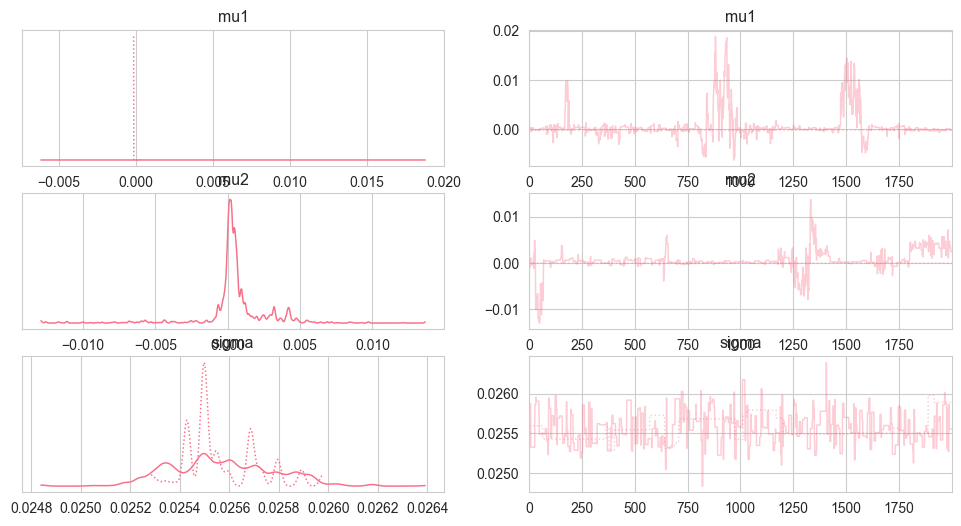

Most probable change point: 2005-02-23 00:00:00


In [8]:
# Summary
print(pm.summary(trace, var_names=['mu1', 'mu2', 'sigma']))

# Plot trace
pm.plot_trace(trace, var_names=['mu1', 'mu2', 'sigma'])
plt.show()

# Posterior of tau
tau_posterior = trace.posterior['tau'].values.flatten()
change_day = int(np.median(tau_posterior))
change_date = df_clean.iloc[change_day]['Date']
print(f"Most probable change point: {change_date}")


🎯 Most Probable Change Point:
   → Index: 4490
   → Date: 2005-02-23
   → 95% CI: [1987-07-24, 2022-10-06]


<Figure size 1000x400 with 0 Axes>

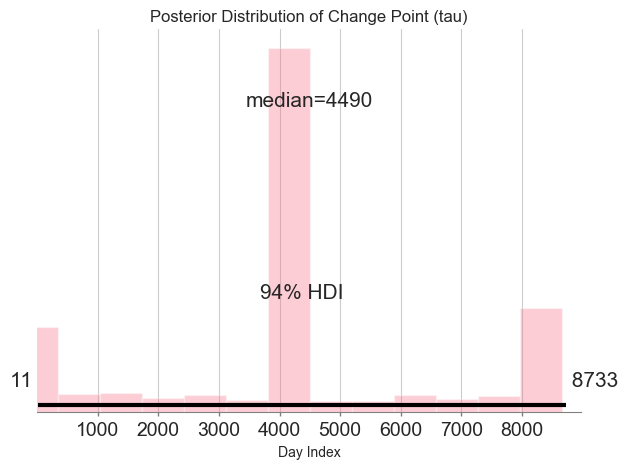

In [9]:
# Extract posterior of tau
tau_posterior = trace.posterior['tau'].values.flatten()

# Most probable change point
change_day = int(np.median(tau_posterior))
change_date = df_clean.iloc[change_day]['Date']

print(f"\n🎯 Most Probable Change Point:")
print(f"   → Index: {change_day}")
print(f"   → Date: {change_date.strftime('%Y-%m-%d')}")
print(f"   → 95% CI: [{df_clean.iloc[np.percentile(tau_posterior, 2.5).astype(int)]['Date'].strftime('%Y-%m-%d')}, "
      f"{df_clean.iloc[np.percentile(tau_posterior, 97.5).astype(int)]['Date'].strftime('%Y-%m-%d')}]")

# Plot posterior distribution of tau
plt.figure(figsize=(10, 4))
az.plot_posterior(trace, var_names=['tau'], round_to=0, point_estimate='median')
plt.title("Posterior Distribution of Change Point (tau)")
plt.xlabel("Day Index")
plt.tight_layout()
plt.savefig("change_point_posterior.png", dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


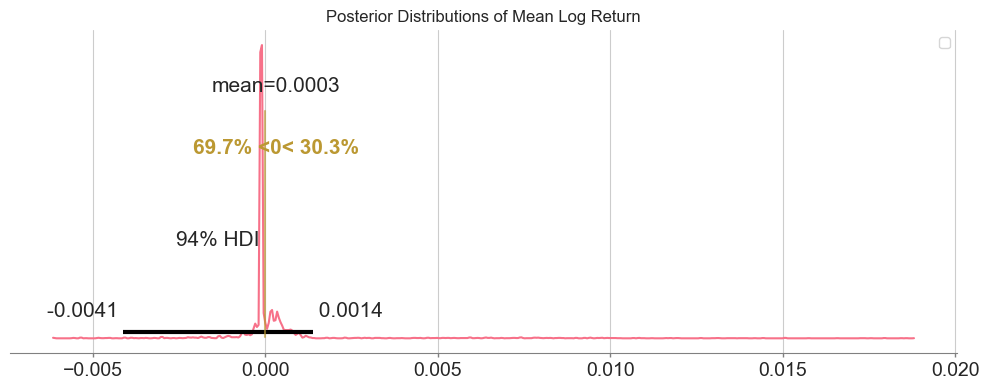


📊 Impact Analysis:
   → Probability that mean increased after change: 79.3%
   → Average change in mean log return: -0.000051
   → Suggests a 0.0051% average daily decrease in price after the change.


In [10]:
# Extract mu1 and mu2
mu1_post = trace.posterior['mu1'].values.flatten()
mu2_post = trace.posterior['mu2'].values.flatten()

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 4))
az.plot_posterior(
    {'μ (Before)': mu1_post, 'μ (After)': mu2_post},
    kind='kde',
    ax=ax,
    ref_val=0
)
ax.set_title("Posterior Distributions of Mean Log Return")
ax.legend()
plt.tight_layout()
plt.savefig("mean_comparison.png", dpi=300)
plt.show()

# Quantify the difference
prob_increase = np.mean(mu2_post > mu1_post)
effect_size = np.mean(mu2_post - mu1_post)

print(f"\n📊 Impact Analysis:")
print(f"   → Probability that mean increased after change: {prob_increase:.1%}")
print(f"   → Average change in mean log return: {effect_size:+.6f}")
if effect_size > 0:
    print(f"   → Suggests a {effect_size*100:.4f}% average daily increase in price after the change.")
else:
    print(f"   → Suggests a {abs(effect_size)*100:.4f}% average daily decrease in price after the change.")

In [11]:
# Define key events
events = {
    '2020-03-08': 'Russia-Saudi Price War',
    '2016-11-30': 'OPEC Production Cuts',
    '2014-11-27': 'OPEC No-Cut Decision',
    '2008-09-15': 'Global Financial Crisis',
    '2022-02-24': 'Russia Invades Ukraine'
}

print(f"\n🔍 Detected Change Point: {change_date.strftime('%Y-%m-%d')}")
print("Comparing with known events:")

for event_date, event_name in events.items():
    delta = abs((pd.to_datetime(event_date) - change_date).days)
    if delta < 60:  # Within 2 months
        print(f"   ✅ Close to '{event_name}' on {event_date} (±{delta} days)")


🔍 Detected Change Point: 2005-02-23
Comparing with known events:


In [12]:
# Extract price before and after
pre_mask = df_clean['Date'] < change_date
post_mask = df_clean['Date'] >= change_date

price_before = df_clean.loc[pre_mask, 'Price']
price_after = df_clean.loc[post_mask, 'Price']

avg_before = price_before.mean()
avg_after = price_after.mean()
pct_change = (avg_after - avg_before) / avg_before * 100

print(f"\n💡 Quantitative Impact Statement:")
print(f"Following the structural break detected around {change_date.strftime('%Y-%m-%d')},")
print(f"the average Brent oil price shifted from ${avg_before:.2f} to ${avg_after:.2f},")
print(f"a {'increase' if pct_change > 0 else 'decrease'} of {pct_change:+.1f}%.")
print(f"There is a {prob_increase:.1%} probability that the underlying return process worsened.")


💡 Quantitative Impact Statement:
Following the structural break detected around 2005-02-23,
the average Brent oil price shifted from $21.43 to $75.60,
a increase of +252.8%.
There is a 79.3% probability that the underlying return process worsened.
